In [1]:
def calc_p_impact(x,y,original_swap_x,fee):
    """
    @notice calculate slippage when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    # TODO: Also need to incorporate original_swap_y in case we are selling collateral
    # TODO: Need to incorporate concentrated liquidity (e.g., no more liquidity beyond ]a, b[)
    # TODO: Need to incorproate the StableSwap invariant for crvUSD pool liquidity
    # x = 2e6 
    # y = 1e3
    k = x*y
    original_price = x/y
    # original_swap_x = 10e3
    # fee=0.00
    swap_x = original_swap_x*(1-fee)
    new_x = x + swap_x
    new_y = k/new_x
    swap_y = y-new_y
    trade_price = swap_x/swap_y
    new_price = new_x/new_y
    return(trade_price)

calc_p_impact(2e6,1e3,10e3,0.00) 

0.0050000000000108005

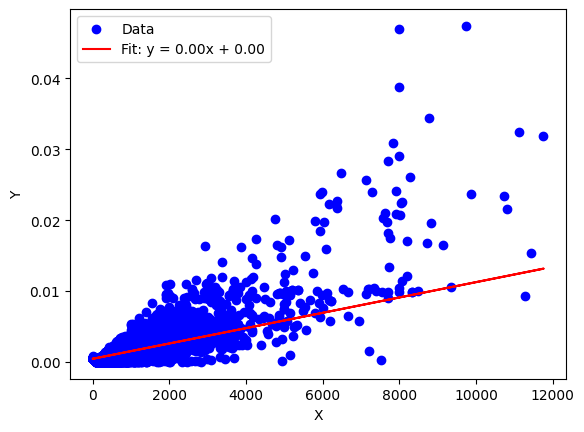

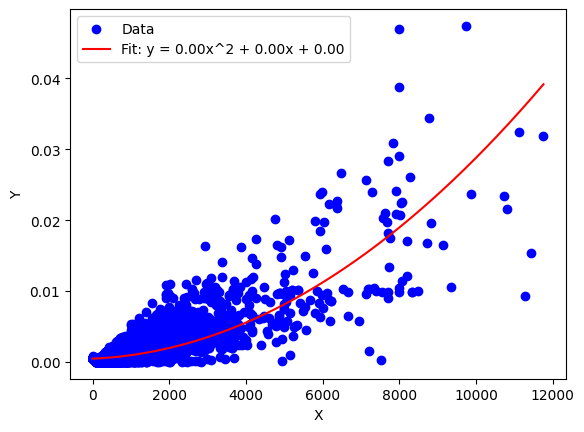

2.602424822058012e-10 2.3009044333523045e-07 0.0004613261845851614


In [17]:
# Empirical slippage analysis
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

with open("weth_usdc_005_tier_trades.csv","r") as infile:
    data = pd.read_csv(infile)

with open("weth_usdc_005_tier_trades2.csv","r") as infile:
    data2 = pd.read_csv(infile)

data3 = pd.concat([data,data2]).drop_duplicates()
data3["WETH"]=data3["amount1"].apply(lambda x: int(x) / 1e18)
data3["USDC"]=data3["amount0"].apply(lambda x: int(x)/1e6)
data3["price_implied"] = data3["price_implied"]/1e18
data3["price_actual"] = data3["price_actual"]/1e18
data3["price_impact"]=abs(data3["price_implied"]-data3["price_actual"])/data3["price_implied"]
data3["evt_block_time"] = pd.to_datetime(data3['evt_block_time'], utc=True)
data3['unix_timestamp'] = data3['evt_block_time'].astype(int) // 10**9
slope, intercept = np.polyfit(data3["WETH"], data3["price_impact"], 1)

#Linear regression
# Generate Y-values based on the regression model
y_fit = slope * data3["WETH"] + intercept
plt.scatter(x=data3["WETH"], y=data3["price_impact"], label='Data', color='blue')
plt.plot(data3["WETH"], y_fit, label=f'Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## Quadratic Regression
a, b, c = np.polyfit(data3["WETH"], data3["price_impact"], 2)
x_fit = np.linspace(min(data3["WETH"]), max(data3["WETH"]), 500)
y_fit = a * x_fit**2 + b * x_fit + c
plt.scatter(x=data3["WETH"], y=data3["price_impact"], label='Data', color='blue')
plt.plot(x_fit, y_fit,label=f'Fit: y = {a:.2f}x^2 + {b:.2f}x + {c:.2f}', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

print(a,b,c)

In [23]:
# new slippage function based on empirical analysis
def slippage(x,fee):
    """
    @notice calculate slippage when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    a,b,c = (2.602424822058012e-10,2.3009044333523045e-07,0.0004613261845851614)
    return(a*x**2+b*x+c)

slippage_x = np.logspace(-6,6, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
print(slippage_x)
slippage_y = [slippage(x,0.00) for x in slippage_x]
fig=px.line(x=slippage_x, y=slippage_y)
fig.show()

[1.00000000e-06 1.75751062e-06 3.08884360e-06 5.42867544e-06
 9.54095476e-06 1.67683294e-05 2.94705170e-05 5.17947468e-05
 9.10298178e-05 1.59985872e-04 2.81176870e-04 4.94171336e-04
 8.68511374e-04 1.52641797e-03 2.68269580e-03 4.71486636e-03
 8.28642773e-03 1.45634848e-02 2.55954792e-02 4.49843267e-02
 7.90604321e-02 1.38949549e-01 2.44205309e-01 4.29193426e-01
 7.54312006e-01 1.32571137e+00 2.32995181e+00 4.09491506e+00
 7.19685673e+00 1.26485522e+01 2.22299648e+01 3.90693994e+01
 6.86648845e+01 1.20679264e+02 2.12095089e+02 3.72759372e+02
 6.55128557e+02 1.15139540e+03 2.02358965e+03 3.55648031e+03
 6.25055193e+03 1.09854114e+04 1.93069773e+04 3.39322177e+04
 5.96362332e+04 1.04811313e+05 1.84206997e+05 3.23745754e+05
 5.68986603e+05 1.00000000e+06]
